## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [50]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

In [51]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [123]:
hparams = create_hparams()
hparams.sampling_rate = 22050
hparams.max_decoder_steps=100000
# hparams.max_decoder_steps=10000
print(hparams)

epochs=500,iters_per_checkpoint=1000,seed=1234,dynamic_loss_scaling=True,fp16_run=False,distributed_run=False,dist_backend=nccl,dist_url=tcp://localhost:54321,cudnn_enabled=True,cudnn_benchmark=False,ignore_layers=['embedding.weight'],load_mel_from_disk=False,training_files=filelists/ljs_audio_text_train_filelist.txt,validation_files=filelists/ljs_audio_text_val_filelist.txt,text_cleaners=['english_cleaners'],max_wav_value=32768.0,sampling_rate=22050,filter_length=1024,hop_length=256,win_length=1024,n_mel_channels=80,mel_fmin=0.0,mel_fmax=8000.0,n_symbols=148,symbols_embedding_dim=512,encoder_kernel_size=5,encoder_n_convolutions=3,encoder_embedding_dim=512,n_frames_per_step=1,decoder_rnn_dim=1024,prenet_dim=256,max_decoder_steps=100000,gate_threshold=0.5,p_attention_dropout=0.1,p_decoder_dropout=0.1,attention_rnn_dim=1024,attention_dim=128,attention_location_n_filters=32,attention_location_kernel_size=31,postnet_embedding_dim=512,postnet_kernel_size=5,postnet_n_convolutions=5,use_saved

#### Load model from checkpoint

In [124]:
# checkpoint_path = "tacotron2_statedict.pt"
checkpoint_path = "attenborough_checkpoint_547000"
# checkpoint_path = "neil_tyson_checkpoint_500000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [125]:
waveglow_path = 'waveglow_256channels.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

#### Prepare text input

In [132]:
#text = "In 2005, Halton Borough Council put up a notice to tell the public about its plans to move a path from one place to another. Quite astonishingly, the notice was a 630 word sentence, which picked up one of our Golden Bull awards that year."
text = "Anyways, um... I bought a whole bunch of shungite rocks, do you know what shungite is? Anybody know what shungite is? No, not Suge Knight, I think he's locked up in prison. I'm talkin' shungite. Anyways, it's a two billion year-old like, rock stone that protects against frequencies and unwanted frequencies that may be traveling in the air. That's my story, I bought a whole bunch of stuff. Put 'em around the la casa. Little pyramids, stuff like that.-"
# text = "777777777777777777777777777777777777"
# text = "Let's talk about me, let's talk about the 6 foot 8 frame the 37 in verticle leap. The black steel that drapes down my back aka the bullet proof mullet, the google prototype scopes with built in LCD LED 1080p 3D sony technology. The Ethiopian poisonous caterpillar aka SLICK DADDY."
# text = "And here we have, in the wild, a rare glimpse of what may be a gamer in his natural habitat."
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

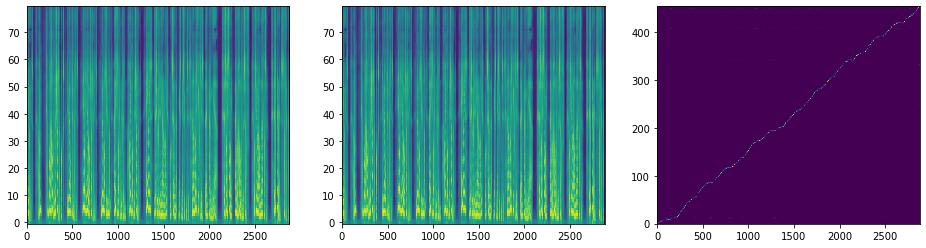

In [133]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [134]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [135]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate)

In [136]:
torch.cuda.empty_cache()